# Assignment 8: BHC Analysis using Python
#### Group: Mitchell Kramer, Nicholas Meyer,  Nikita Tatarinov, Glenn Matlin, Michael Galarnyk

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pickle
from math import ceil

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
import textwrap
import time
import yfinance as yf
from geopy.exc import GeocoderServiceError, GeocoderTimedOut
from geopy.geocoders import Nominatim, get_geocoder_for_service
from networkx.drawing.nx_agraph import graphviz_layout
from scipy.stats import kurtosis, skew, ttest_1samp
from scipy.stats import ttest_1samp
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acovf
from tqdm import tqdm

## Assignment Description

The goal of the assignment is to understand banks financial statements and the risks they are
exposed to. There are a number of issues (listed below) that I want the students to address
in the assignment report. Each group is expected to pick a bank or bank holding company.

1. Draw a random number generated using one of the team member gtid as a seed over theinterval (1, 25). List the seed and your random number at the top of the report.
2. You can select the random number using Python
3. Select the corresponding bank (rank based on size that is the same as the random number) at https://www.ffiec.gov/npw/Institution/TopHoldings
4. If the BHC is not publicly listed in the U.S., redraw the random number
5. I will cold call students in class to describe their findings about their assigned bank in the class

In [3]:
"""
The code below produces the banks we are allowed to present and highlights what BHC we are presenting 
The highlighted bank is only visible when notebook is run locally or output to html.

"""

# Dictionary provided by the user
group_id = {
    "Glenn Matlin": 903738044,
    "Nikita Tatarinov": 903914813,
    "Michael Galarnyk": 903918895,
    "Mitchell Kramer": 903176941,
    "Nicholas Meyer": 903444783,
}

# Initialize a list to hold the random numbers
random_numbers = []

# Iterate over the GTIDs in the group_id dictionary
# For each GTID, we set it as the seed and generate a random number
for name, gtid in group_id.items():
    np.random.seed(gtid)  # Set the seed
    random_num = np.random.randint(1, 26)  # Generate the random number
    random_numbers.append(random_num)  # Append to the list

# Create a DataFrame from the group_id dictionary and the list of random numbers
df = pd.DataFrame(list(group_id.items()), columns=["Student", "GTID"])
df["Random_Number"] = random_numbers  # Add the random numbers to the DataFrame

holding_df = pd.read_csv("data/LargeHoldingCompanies.csv")

# Clean the data by replacing multiple whitespaces with a single space (some companies have a lot of whitespace in names)
holding_df['Name'] = holding_df['Name'].replace(r'\s+', ' ', regex=True)

# Get Bank Names
df = pd.merge(df, holding_df, left_on="Random_Number", right_on="Rank", how="left")

# Define a function to apply a style to each cell in a row
def highlight_specific_row(row, column, value, color='yellow'):
    """
    Highlights a row if a specific column in that row matches a given value.

    Args:
    - row (pd.Series): The row of the DataFrame.
    - column (str): Column name to check the value.
    - value: Value to check against.
    - color (str): Color used for highlighting.

    Returns:
    - list of str: Styles for each cell in the row.
    """
    if row[column] == value:
        return [f'background-color: {color}'] * len(row)
    else:
        return [''] * len(row)

# Apply the styling function to the DataFrame
styled_df = df.style.apply(highlight_specific_row,
                           column='Name',
                           value='JPMORGAN CHASE & CO. ',
                           axis=1)

styled_df

**We decided to analyze the Bank Holding Company JPMorgan (highlighted in yellow above).**

## Section 1: Current Information about the bank

This section should be brief. One paragraph.

<b>1).</b> What are the various business units of the bank (for example, is the bank a pure commercial bank or does it engage in investment banking and other financial businesses?). You can get this information from the firm’s 10-K.

#### Answer

***JPMorgan Chase & Co.***, a global financial powerhouse, operates through **four** distinct business units, each catering to a specific facet of financial services.

1. The **Consumer & Community Banking (CCB)** segment provides a range of services to individual consumers and small businesses, emphasizing personal banking, lending, and investment needs.

2. The **Corporate & Investment Bank (CIB)** delivers a comprehensive suite of investment banking, market-making, and treasury services, focusing on high-end corporate and institutional clients.

3. In the **Commercial Banking (CB)** segment, the focus is on serving larger businesses, offering lending, investment, and financial solutions tailored to their complex needs.

4. The **Asset & Wealth Management (AWM)** arm provides investment and wealth management services, catering to a diverse clientele including high-net-worth individuals and institutional investors.

| Subsidiary Name                                       | Organized Under The Laws Of |
|-------------------------------------------------------|-----------------------------|
| JPMorgan Chase Bank, National Association             | United States               |
| Paymentech, LLC                                       | United States               |
| J.P. Morgan International Finance Limited             | United States               |
| JPMorgan Securities Japan Co., Ltd.                   | Japan                       |
| J.P. Morgan Capital Holdings Limited                  | United Kingdom              |
| J.P. Morgan Securities PLC                            | United Kingdom              |
| J.P. Morgan SE                                        | Germany                     |
| JPMorgan Chase Holdings LLC                           | United States               |
| J.P. Morgan Services India Private Limited            | India                       |
| JPMorgan Asset Management Holdings Inc.               | United States               |
| JPMorgan Distribution Services, Inc.                  | United States               |
| JPMorgan Asset Management International Limited       | United Kingdom              |
| JPMorgan Asset Management (UK) Limited                | United Kingdom              |
| JPMorgan Asset Management Holdings (Luxembourg) S.à r.l. | Luxembourg             |
| JPMorgan Asset Management (Europe) S.à r.l.           | Luxembourg                  |
| J.P. Morgan Investment Management Inc.                | United States               |
| J.P. Morgan Broker-Dealer Holdings Inc.               | United States               |
| J.P. Morgan Securities LLC                            | United States               |
*Table Description: Primary Subsidiaries of JPMC, as disclosed in 10-K*

## Section 2: Understand the Ownership Structure

Analyze (see yahoo finance or Bloomberg or the company’s investor website for the ownership structure). The data needs to be extracted using Python from the relevant URL. This section should be brief. One paragraph with data tables / graphs in the appendix.
1. Institutional Ownership
2. Non-Institutional Ownership
3. Insider Ownership

#### Answer

In [9]:
# NIC Hierarchy Data
hierarchy = pd.read_csv("./data/hierarchy.csv")

### Interactive Corporate Structure Graph
def build_interactive_corporate_structure_graph(hierarchy):
    # Create a directed graph
    G = nx.DiGraph()

    # Iterate over rows in the DataFrame
    for _, row in hierarchy.iterrows():
        # Add a node for the institution
        G.add_node(row["RssdId"], label=row["InstitutionName"])

        # Check if the institution has a parent and add an edge
        if not pd.isna(row["ParentId"]):
            G.add_edge(row["ParentId"], row["RssdId"])

    # Calculate positions of nodes in a hierarchical layout using pygraphviz
    pos = graphviz_layout(G, prog="dot", args="-Gnodesep=1 -Granksep=2")

    # Assign positions to node attributes
    for node in G.nodes:
        G.nodes[node]["pos"] = pos[node]

    # Create Edges
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]["pos"]
        x1, y1 = G.nodes[edge[1]]["pos"]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        line=dict(width=0.5, color="#888"),
        hoverinfo="none",
        mode="lines",
    )

    # Create Nodes
    node_x = []
    node_y = []
    text = []
    for node in G.nodes():
        x, y = G.nodes[node]["pos"]
        node_x.append(x)
        node_y.append(y)
        wrapped_label = textwrap.fill(
            G.nodes[node]["label"], width=15
        )  # Adjust width as needed
        text.append(wrapped_label)

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers+text",
        text=text,
        marker=dict(size=10, line_width=2),  # Adjust node size as needed
        textposition="middle center",
        textfont=dict(size=1),  # Adjust text size as needed
    )

    # Create Figure with increased size
    fig = go.Figure(
        data=[edge_trace, node_trace],
        layout=go.Layout(
            showlegend=False,
            hovermode="closest",
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),  # Hide xticks
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),  # Hide yticks
            margin=dict(b=20, l=5, r=5, t=40),
            width=800,  # Adjust figure width as needed
            height=800,  # Adjust figure height as needed
        ),
    )

    # Export to HTML
    fig.write_html("CorporateStructure.html")
    fig.write_image("CorporateStructure.png")
    
    # Display the Figure
    fig.show()

# build_interactive_corporate_structure_graph(hierarchy)

In [11]:
# Ticker symbol for JPMorgan Chase & Co.
ticker_symbol = "jpm"

# Fetch all available data
jpm = yf.Ticker(ticker_symbol)

*Currently Unused Yahoo API Data*:
```python
financials = jpm.financials

balance_sheet = jpm.balance_sheet

quarterly_balance_sheet = jpm.quarterly_balance_sheet

cashflow = jpm.cashflow

quarterly_cashflow = jpm.quarterly_cashflow

dividends_splits = jpm.actions  # dividends and splits

options = jpm.options

stock_info = jpm.info
```

In [12]:
jpm_historical = jpm.history(period="max")

In [13]:
quarterly_financials = jpm.quarterly_financials

In [14]:
major_holders = jpm.major_holders
major_holders.columns = ["Percent", "Description"]

In [15]:
institutional_holders = jpm.institutional_holders
institutional_holders["Type"] = "Institution"

In [16]:
mutual_fund_holders = jpm.mutualfund_holders
mutual_fund_holders["Type"] = "Non-Institutional"

In [17]:
insider_holders_pct = (
    float(
        major_holders.query("Description == '% of Shares Held by All Insider'")[
            "Percent"
        ]
        .loc[0]
        .replace("%", "")
    )
    / 100
)

In [18]:
total_shares = quarterly_financials.loc[:, "2023-06-30"]["Basic Average Shares"]

In [19]:
as_of_date = pd.to_datetime("2023-06-30")

In [20]:
# Remove time zones from jpm historical data
jpm_historical.index = jpm_historical.index.map(lambda x: x.tz_localize(None))

In [21]:
share_price = (
    jpm_historical.loc[as_of_date]["High"] + jpm_historical.loc[as_of_date]["Low"]
) / 2

In [22]:
insider_shares = int(insider_holders_pct * total_shares)

In [23]:
insider_value = int(insider_shares * share_price)

In [24]:
insider_trading = pd.DataFrame(
    pd.Series(
        {
            "Holder": "Insiders",
            "Shares": insider_shares,
            "Date Reported": pd.Timestamp("2023-06-30 00:00:00"),
            "% Out": insider_holders_pct,
            "Value": insider_value,
            "Type": "Insiders",
        }
    )
).T

In [25]:
ownership = pd.concat([insider_trading, institutional_holders, mutual_fund_holders])

other_owners = pd.DataFrame(
    pd.Series(
        {
            "Holder": "Information Unavailable",
            "Shares": int(total_shares - ownership["Shares"].sum()),
            "Date Reported": pd.Timestamp("2023-06-30 00:00:00"),
            "% Out": 1 - ownership["% Out"].sum(),
            "Value": int(int(total_shares - ownership["Shares"].sum()) * share_price),
            "Type": "Other",
        }
    )
).T

ownership = pd.concat([ownership, other_owners])

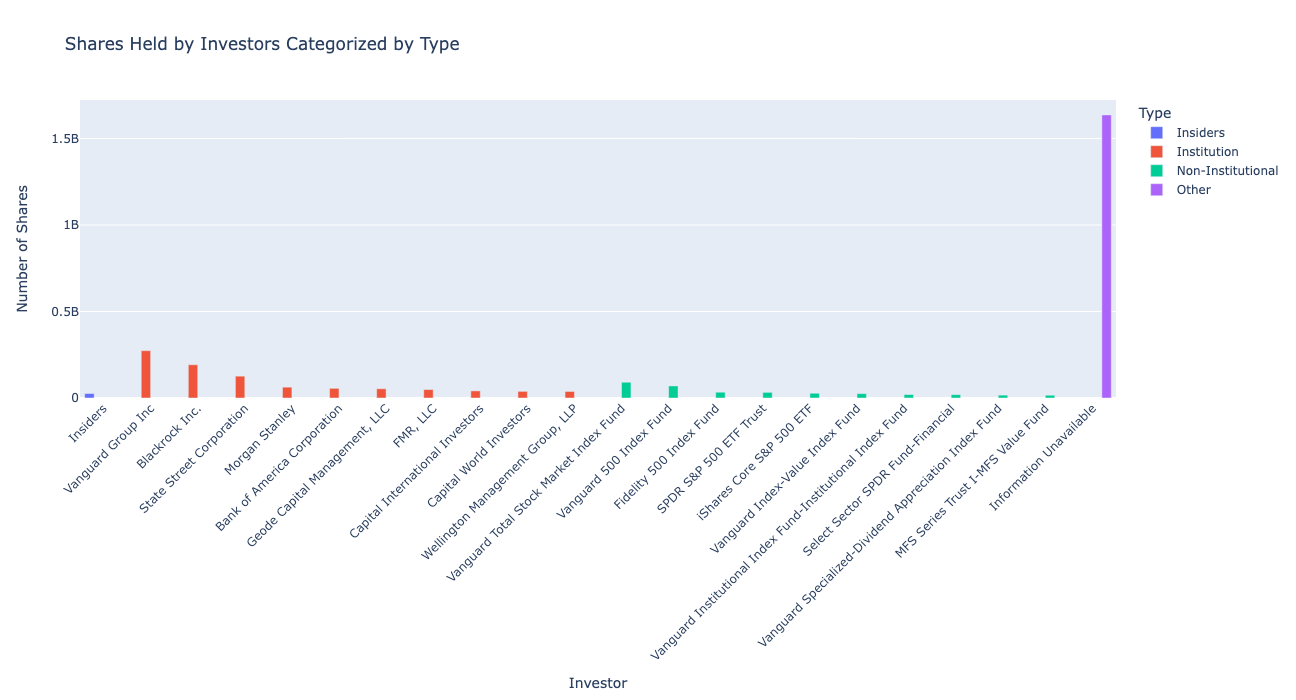

In [30]:
fig = px.bar(
    ownership, 
    x='Holder', 
    y='Shares', 
    color='Type',
    barmode='group',
    title='Shares Held by Investors Categorized by Type'
)
fig.update_layout(
    xaxis_title='Investor',
    yaxis_title='Number of Shares',
    xaxis_tickangle=-45,
    width=900,
    height=700
)

# Export to HTML
# fig.write_html("SharedHeldByInvestors.html")
# fig.write_image("SharedHeldByInvestors.png")
# fig.show()

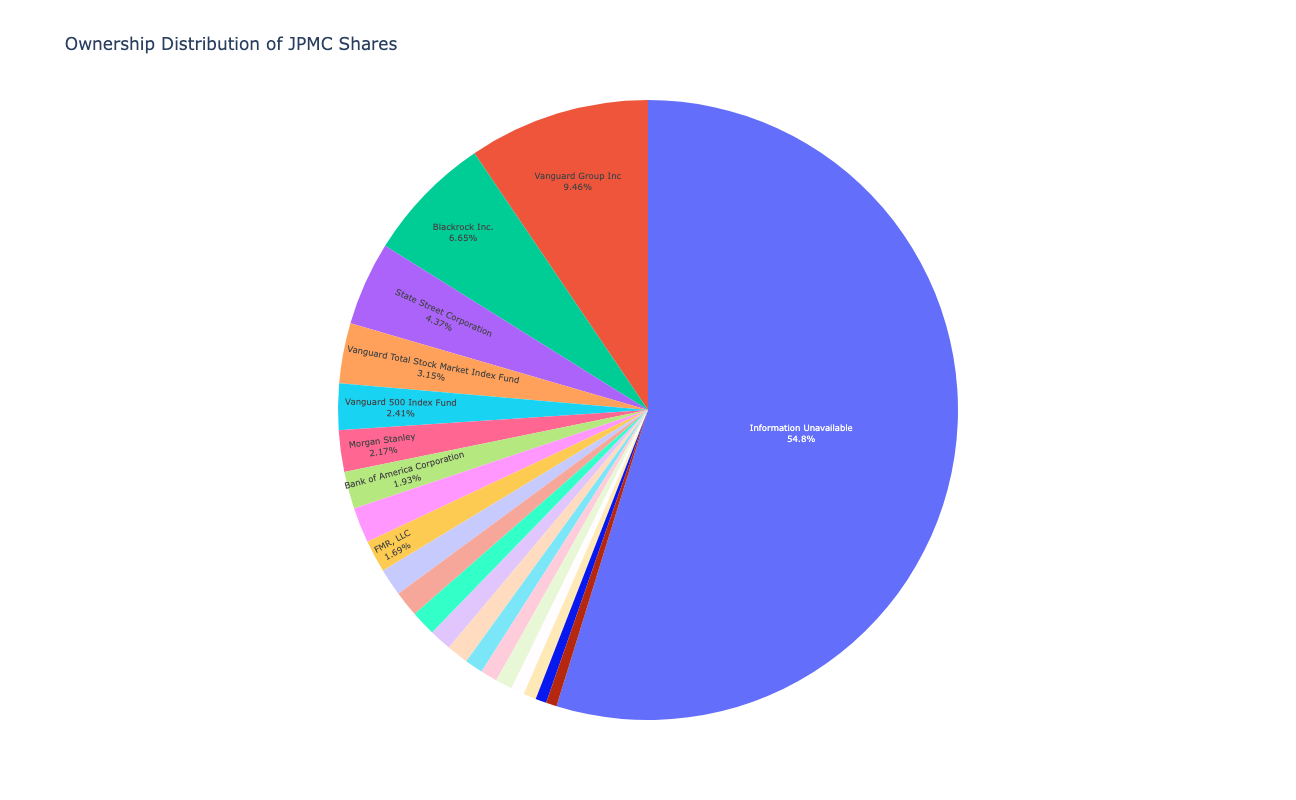

In [32]:
fig = px.pie(ownership, 
             values='% Out', 
             names='Holder', 
             title='Ownership Distribution of JPMC Shares')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    uniformtext_minsize=8, 
    uniformtext_mode='hide',
    showlegend=False,
    width=800,
    height=800
)

# Export to HTML
# fig.write_html("Piechart_Ownership_Distribution_Of_JPMC_Shares.html")
# fig.write_image("PieChartSharesHeld.png")
# fig.show()

#### Are the insiders buying or selling the stock recently?
Obviously, there was major news recently about [JPMorgan CEO Jamie Dimon to sell 1 million shares for about 140 million dollars](https://www.wsj.com/finance/banking/jpmorgan-ceo-dimon-family-to-sell-1m-shares-of-bank-e6047019). 

You can see the more information about insider trading below. It was scraped off their corporate webpage. 

#### Answer

In [33]:
insider_trades_6mo = pd.read_excel('./data/insider_trades.xlsx', sheet_name='Last 6 Months')

In [34]:
insider_trades_6mo

Category  Shares  Trans
0                      Purchases  246322   20.0
1                          Sales  189756   14.0
2    Net Shares Purchased (Sold)   56566   34.0
3      Total Insider Shares Held  25.59M    NaN
4  % Net Shares Purchased (Sold)   0.002    NaN

In [35]:
insider_trades_2yr = pd.read_excel('./data/insider_trades.xlsx', sheet_name='Last 2 Years')

In [36]:
insider_trades_2yr.sort_values('Date', ascending=False, inplace=True)

In [37]:
insider_trades_2yr.head()

Insider                     Role  \
0            DIMON JAMES  Chief Executive Officer   
1      KORABLINA ELENA A                  Officer   
2        PETNO DOUGLAS B                  Officer   
6      NOVAKOVIC PHEBE N                 Director   
9  FLYNN TIMOTHY PATRICK                 Director   

                                     Transaction      Type    Value  \
0            Stock Gift at price 0.00 per share.  Indirect      0.0   
1                                            NaN    Direct      NaN   
2            Stock Gift at price 0.00 per share.    Direct      0.0   
6  Stock Award(Grant) at price 145.02 per share.    Direct  32500.0   
9  Stock Award(Grant) at price 145.02 per share.    Direct  38750.0   

        Date  Shares  
0 2023-11-01  100359  
1 2023-10-25    1706  
2 2023-10-23     678  
6 2023-09-29     224  
9 2023-09-29     267

## Section 3: How do the markets view the bank

This section should be a short summary with the corresponding tables in the Appendix
### 1. Stock Return, Beta, Volatility (compute using Python, translate your previous Rcode into Python)

In [38]:
# DSF for JPM

dir_path = './data/3/{}'

def read_crsp(data_path):
    crsp_df = pd.read_csv(data_path,
                          usecols=['date', 'RET', 'vwretd'],
                          dtype={'RET': str}).rename(columns={'vwretd': 'MKT'}) \
        .sort_values(by=['date']) \
        .reset_index(drop=True)

    crsp_df['date'] = pd.to_datetime(crsp_df['date'])

    crsp_df['RET'].replace(['B', 'C'], np.nan, inplace=True)
    crsp_df['RET'] = crsp_df['RET'].astype('float64')

    crsp_df.dropna(inplace=True)
    crsp_df.reset_index(drop=True, inplace=True)

    crsp_df.info()
    return crsp_df

In [39]:
jpm_ret_df = read_crsp(dir_path.format('jpm_dsf.csv'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10589 entries, 0 to 10588
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    10589 non-null  datetime64[ns]
 1   RET     10589 non-null  float64       
 2   MKT     10589 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 248.3 KB


In [40]:
### Fama-French dataset
fama_french_df = pd.read_csv(dir_path.format('F-F_Research_Data_5_Factors_2x3_daily.CSV'),
                             header=2, usecols=[0, 2, 3, 4, 5, 6]).rename(columns={'Unnamed: 0': 'date'})
fama_french_df.loc[:, 'date'] = fama_french_df['date'].apply(
    lambda val: str(val)[:4] + '-' + str(val)[4:6] + '-' + str(val)[6:])
fama_french_df['date'] = pd.to_datetime(fama_french_df['date'])
fama_french_df['SMB'] /= 100
fama_french_df['HML'] /= 100
fama_french_df['RMW'] /= 100
fama_french_df['CMA'] /= 100
fama_french_df['RF'] /= 100
fama_french_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15146 entries, 0 to 15145
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    15146 non-null  datetime64[ns]
 1   SMB     15146 non-null  float64       
 2   HML     15146 non-null  float64       
 3   RMW     15146 non-null  float64       
 4   CMA     15146 non-null  float64       
 5   RF      15146 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 710.1 KB


In [41]:
### Merging datasets

jpm_ret_df = jpm_ret_df.merge(fama_french_df, on='date')
jpm_ret_df['EXCMKT'] = jpm_ret_df['MKT'] - jpm_ret_df['RF']
jpm_ret_df['EXCRET'] = jpm_ret_df['RET'] - jpm_ret_df['RF']
jpm_ret_df.drop(columns=['RET', 'MKT', 'RF'], inplace=True)
jpm_ret_df['year'] = jpm_ret_df['date'].apply(lambda val: val.year)
jpm_ret_df.info()

### 1.4. Building table
def build_model(df, y):
    df = sm.add_constant(df)
    model = sm.OLS(y, df).fit()
    return model

ret_sqr = jpm_ret_df[jpm_ret_df['date'] < '2001-01-01']['EXCRET'].mean() ** 2
sigma_sqr = jpm_ret_df[jpm_ret_df['date'] < '2001-01-01']['EXCRET'].var()
lambda_sigma = 0.94

jpm_ret_df = jpm_ret_df[jpm_ret_df['date'] >= '2001-01-01']
ret_table = pd.DataFrame(columns=['year', 'compound_return', 'alpha',
                                  'beta_mkt', 'beta_smb', 'beta_hml',
                                  'beta_rmw', 'beta_cma', 'volatility'])

jpm_ret_df_by_year = jpm_ret_df.groupby(['year'])
for year, df in jpm_ret_df_by_year:
    model = build_model(df[['EXCMKT', 'SMB', 'HML', 'RMW', 'CMA']], df['EXCRET'])
    for ret_t in df['EXCRET']:
        sigma_sqr = lambda_sigma * sigma_sqr + (1 - lambda_sigma) * ret_sqr
        ret_sqr = ret_t ** 2
    ret_table.loc[len(ret_table.index)] = [year[0], np.prod(1 + df['EXCRET']) - 1,
                                           model.params['const'], model.params['EXCMKT'],
                                           model.params['SMB'], model.params['HML'],
                                           model.params['RMW'], model.params['CMA'],
                                           sigma_sqr]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10589 entries, 0 to 10588
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    10589 non-null  datetime64[ns]
 1   SMB     10589 non-null  float64       
 2   HML     10589 non-null  float64       
 3   RMW     10589 non-null  float64       
 4   CMA     10589 non-null  float64       
 5   EXCMKT  10589 non-null  float64       
 6   EXCRET  10589 non-null  float64       
 7   year    10589 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 661.9 KB


In [42]:
ret_table

year  compound_return     alpha  beta_mkt  beta_smb  beta_hml  beta_rmw  \
0   2001.0        -0.204531 -0.000030  1.479311 -0.039720  0.100642  0.651422   
1   2002.0        -0.318383  0.000737  1.848878 -0.127484  0.819563 -0.262670   
2   2003.0         0.586271  0.000327  1.589808 -0.299826  0.394503 -0.141627   
3   2004.0         0.086952 -0.000295  1.255114 -0.251148  0.453381 -0.124438   
4   2005.0         0.026714 -0.000130  1.015050 -0.405563  0.015399 -0.254670   
5   2006.0         0.198639 -0.000067  1.453476 -0.419332  0.589940 -0.103977   
6   2007.0        -0.110381  0.000651  1.338313 -0.300617  1.843523 -0.475738   
7   2008.0        -0.263042  0.000860  0.999843  0.310565  2.326508  0.312156   
8   2009.0         0.342177  0.001441  0.849001 -0.250709  2.453395 -0.080665   
9   2010.0         0.021081 -0.000031  0.765304 -0.742226  1.287846 -1.240330   
10  2011.0        -0.199905  0.000014  1.110028  0.135980  2.125427 -0.048144   
11  2012.0         0.361501 -0.000025  1.218508 -0.377989  2.189306 -0.425463   
12  2013.0         0.367143  0.000106  1.044935 -0.438855  1.257647 -0.631064   
13  2014.0         0.098806 -0.000019  1.123293 -0.336636  0.877315 -1.045902   
14  2015.0         0.083669  0.000526  1.178898 -0.091535  0.960990 -0.633775   
15  2016.0         0.342813  0.000147  1.062581  0.017244  1.383184 -0.581050   
16  2017.0         0.257052  0.000422  1.226275 -0.089183  1.360813 -0.261096   
17  2018.0        -0.083052  0.000612  1.100480 -0.321657  1.417167 -0.358251   
18  2019.0         0.441583  0.000706  1.131948 -0.321382  1.261673 -0.140044   
19  2020.0        -0.058921  0.000992  1.063879 -0.476466  1.381993 -0.583854   
20  2021.0         0.277246 -0.000178  0.998507 -0.302459  1.142166 -0.457951   
21  2022.0        -0.138398  0.000191  1.071096 -0.210631  0.984980 -0.060876   

    beta_cma  volatility  
0  -0.522163    0.000474  
1  -0.033152    0.001007  
2  -0.136953    0.000068  
3  -0.361929    0.000061  
4  -0.469268    0.000044  
5   0.082935    0.000071  
6  -0.286607    0.000467  
7  -0.363371    0.004540  
8  -3.075453    0.000224  
9   0.547433    0.000237  
10 -0.883781    0.000924  
11 -0.485749    0.000138  
12 -0.133299    0.000107  
13  0.336292    0.000149  
14 -0.880263    0.000221  
15 -1.122242    0.000121  
16 -0.705448    0.000100  
17 -1.016609    0.000305  
18 -0.711634    0.000075  
19 -0.483601    0.000385  
20 -0.408943    0.000136  
21 -0.803211    0.000155

In [31]:
def plot_df(df, title):
    plt.figure(figsize=(15, 8))
    for column in df:
        plt.plot(df[column], '-', label=column)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.savefig(str(title) + ".png")
    plt.show()

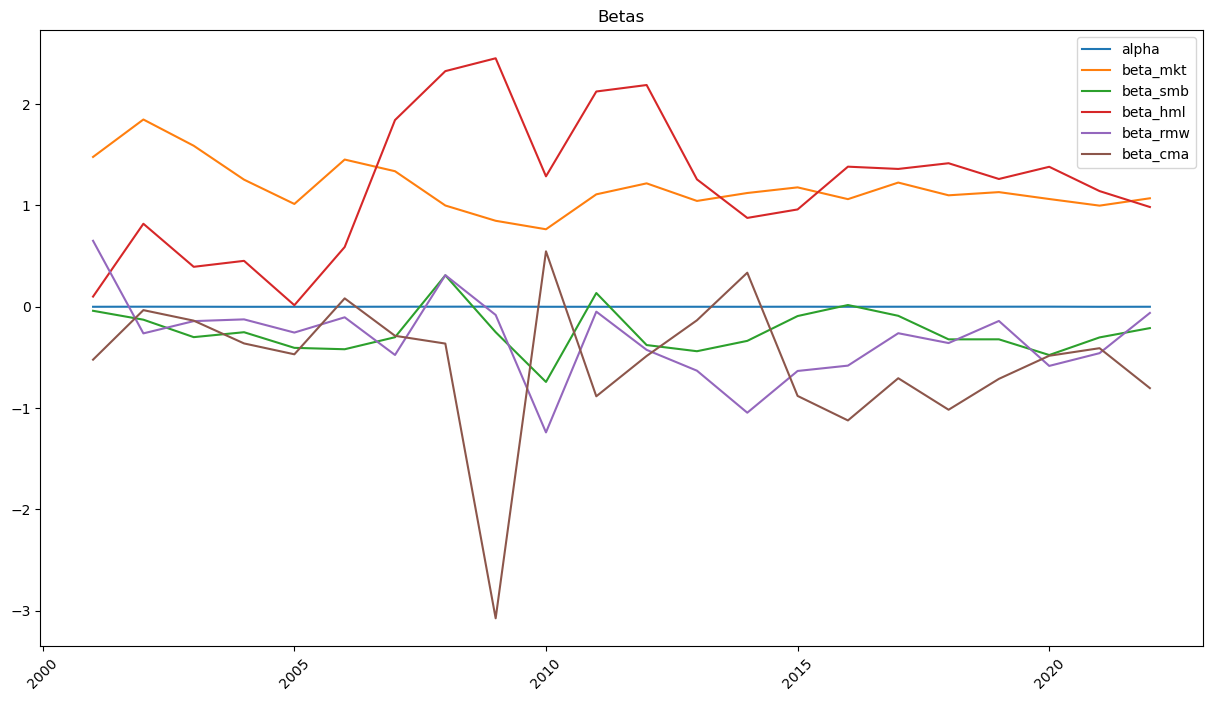

In [32]:
plot_df(ret_table[['year', 'alpha', 'beta_mkt', 'beta_smb', 'beta_hml', 'beta_rmw', 'beta_cma']]
        .set_index('year'), 'Betas')


**Interpretation of the JPM Betas Chart:**

The chart displays several time-series data points representing different 'betas' from the year 2000 onwards:

- `alpha`: Represents the excess return of a portfolio over the benchmark. It oscillates around the zero line, indicating varying performance relative to the benchmark over time.
- `beta_mkt`: Shows the sensitivity of JPM's returns to the market returns. A consistent value above 1 suggests that JPM's returns are more volatile than the market.
- `beta_smb` (Size Factor): Indicates JPM's sensitivity to small minus big cap returns. It stays mostly around zero, suggesting a neutral stance towards size factor risks.
- `beta_hml` (Value Factor): Measures the exposure to high book-to-market minus low book-to-market returns. The fluctuations imply varying degrees of value factor risk over time.
- `beta_rmw`: Reflects the robust minus weak operating profitability factor. The movements around the zero line suggest a changing profile of profitability-based risk.
- `beta_cma`: Indicates exposure to conservative minus aggressive investment styles. The line near zero suggests a balanced investment style risk exposure.

Each line's trend and position relative to the zero line provide insight into JPM's risk profile and investment strategy adjustments over the years.


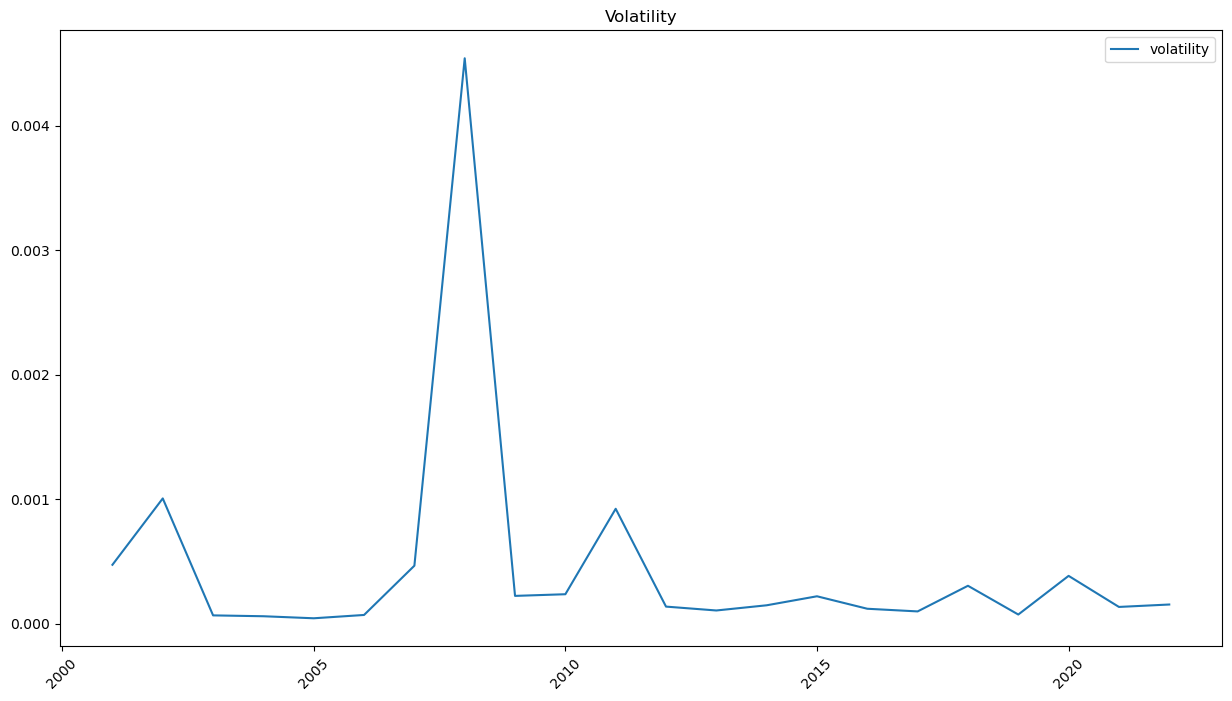

In [33]:
plot_df(ret_table[['year', 'volatility']].set_index('year'), 'Volatility')

**JPM Share Volatility Over Time**

- **Early to Mid-2000s**: There is a moderate increase in volatility, suggesting some market events or company-specific news that may have caused slight uncertainty among investors.

- **Financial Crisis (Around 2008-2009)**: A pronounced spike in volatility is observed, which is the most significant on the graph. This aligns with the global financial crisis, where heightened volatility was a common feature across financial markets.

- **Post-Crisis Period**: After the crisis, volatility decreases but exhibits another peak, albeit smaller compared to the crisis peak. This period may reflect the market's adjustment and recovery phase, with occasional financial or operational challenges for JPM.

- **2010s Onwards**: The graph shows a general trend of decreasing and stabilizing volatility, punctuated by minor fluctuations. This suggests a return to relative normalcy in the market's perception of JPM's share stability, although not without periodic market or economic events affecting its volatility.

**Note:** For a detailed analysis, the specific data points and dates should be reviewed to correlate these observations with historical market events and JPM's financial performance.

### 2. [Short-interest in the bank’s stock. days it takes to cover](https://www.benzinga.com/quote/JPM/short-interest) the short-interest (from the exchange or other sources)

In [34]:
short_interest_df = pd.read_csv(dir_path.format('short_interest.csv'))
short_interest_df['date'] = pd.to_datetime(short_interest_df['date'])
short_interest_df.info()
short_interest_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            48 non-null     datetime64[ns]
 1   short_interest  48 non-null     int64         
 2   days_to_cover   48 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.3 KB


date  short_interest  days_to_cover
0 2023-11-09        16205765           1.48
1 2023-10-24        16114613           1.43
2 2023-10-10        17414414           2.21
3 2023-09-26        20154592           2.16
4 2023-09-12        18565057           2.39

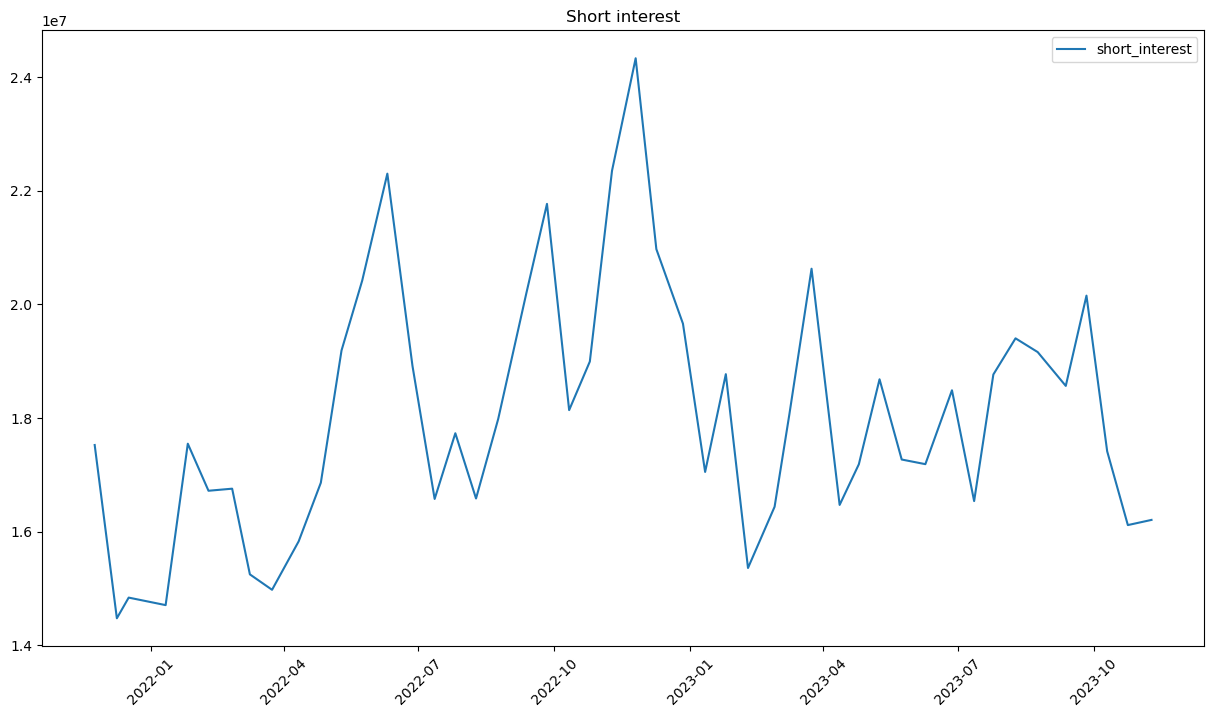

In [35]:
plot_df(short_interest_df[['date', 'short_interest']].set_index('date'), 'Short interest')

**Analysis of JPM's Short Interest Over Time:**

The graph shows the short interest in JPM shares from early 2022 through the end of 2023. Here are some notable observations:

- **Early 2022**: The year starts with a relatively lower short interest, which could suggest a more optimistic market sentiment or less negative speculation about JPM's future performance.

- **Mid-2022**: There is a sharp increase in short interest, peaking significantly above the previous months. This spike may indicate a growing bearish sentiment among investors, perhaps due to specific events or negative news related to JPM or its sector.

- **Late 2022**: After the peak, short interest decreases, suggesting that some short sellers may have closed their positions, possibly taking advantage of lower stock prices to buy back shares profitably.

**Note:** This analysis is purely based on the graphical representation of the short interest. For a comprehensive understanding, it would be important to consider the context of market conditions, JPM's financial performance, and relevant news during these periods.

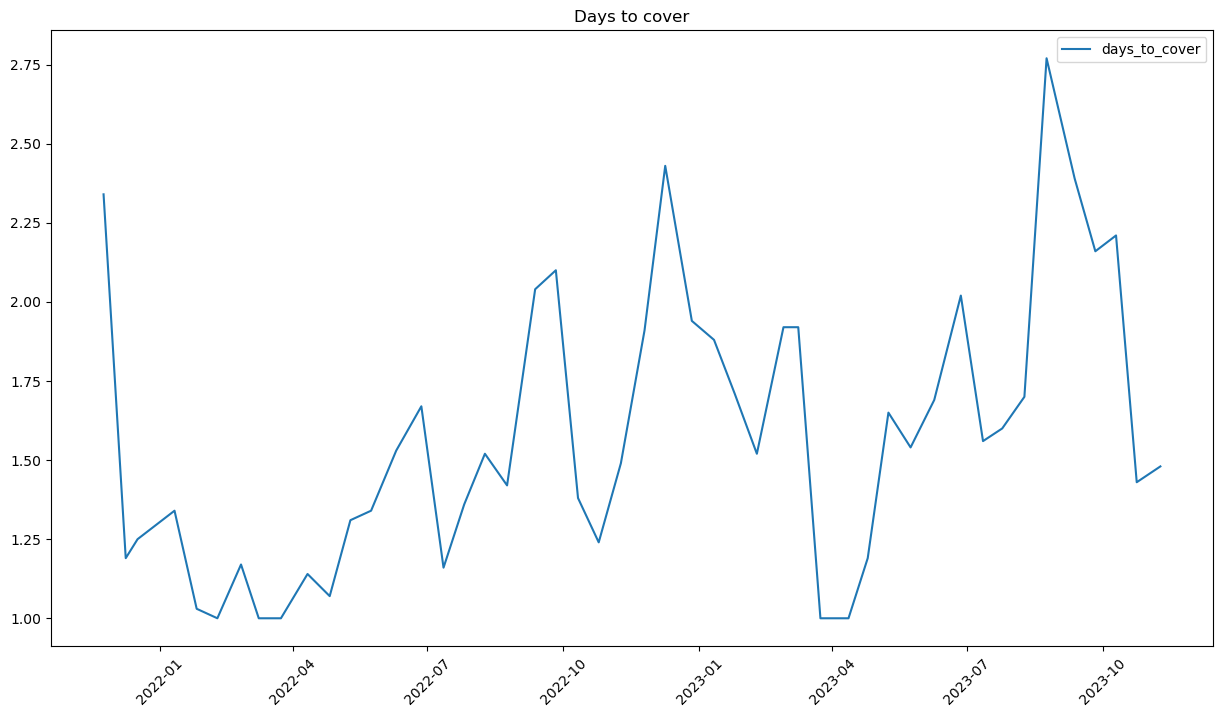

In [36]:
plot_df(short_interest_df[['date', 'days_to_cover']].set_index('date'), 'Days to cover')

**Days to cover(Short Interest Ratio):**

Days to Cover (Short Interest Ratio): This is a measure of the number of days it would take short sellers to buy back all the shares they have sold short, based on the average daily volume of shares traded on the stock exchange. It is calculated by dividing the short interest by the average daily volume. A higher days to cover ratio suggests that it would take more time to buy back the shorted shares, which could increase the risk of a short squeeze, especially if the stock price starts to rise for any reason.

### 3. CDS prices (from bloomberg or some other source). Can show a graph using this data

In [37]:
cds_prices_df = pd.read_csv(dir_path.format('cds_prices.csv'))
cds_prices_df.info()
cds_prices_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    24 non-null     object 
 1   price   24 non-null     float64
 2   open    24 non-null     float64
 3   high    24 non-null     float64
 4   low     24 non-null     float64
dtypes: float64(4), object(1)
memory usage: 1.1+ KB


date  price   open   high    low
0  2023-11-01  57.22  68.18  68.18  57.22
1  2023-10-01  68.18  64.73  72.55  62.25
2  2023-09-01  64.73  55.22  65.25  55.16
3  2023-08-01  55.22  51.22  59.16  51.22
4  2023-07-01  51.22  61.15  63.15  51.22

## Observations:

- Over the months leading up to November 2023, there is a general downward trend in the closing price from July, indicating a bearish period.
- The opening price fluctuates, but in November, it is significantly higher than the closing price, suggesting a sharp decline during the month.
- The range between the high and low prices seems to widen in October, which may imply increased volatility during that month.

### 4. Credit ratings
See "credit_ratings.xsl"

### 5. Analyst opinions

See reports By Stephen Biggar and Kenneth Leon

## Section 4: Understanding Bank Call Reports

To help with section 5-8 below, first do the following
1. Download the PDF format of the quarterly FRY9-C (as of Dec 2022) for your bank by following your bank link
* https://www.ffiec.gov/npw/Institution/TopHoldings
2. Browse through the statement (you can use control+f to find some of the items) to get the relevant item number for some of the following variables
3. In order to understand the variables, you can see FDIC performance report and description of the ratios.
* https://www.federalreserve.gov/boarddocs/supmanual/bhcpr/UsersGuide13/default.htm
4. Now download the Q4 (as of Dec 12/31) FRY9-C for for the bank for the last five years in CSV format (not manually, make a call inside your python program) by following the bank URL
5. Keep only the variables required for sections 5-8. Stack the quarterly data
6. Plot the variables for the past five years
7. Comment on the patterns that you observe in the data. 1-2 lines per variable. Discuss in the group first.

In [ ]:
dir_path = './data/4/{}'
file_path = 'FRY9C_1039502_{}1231.csv'
var_key_dict = {'earnings': 'BHCK4340',
                'net interest margins': 'BHCK4074',
                'non-interest income': 'BHCK4079',
                'net gains on sales of loans': 'BHCK8560',
                'total loans': 'BHCK4635',
                'provision for loan losses': 'BHCKJJ33'
                }

ratio_df = pd.DataFrame(columns=['year'] + list(var_key_dict.keys()))

for year in range(2018, 2023):
    df = pd.read_csv(dir_path.format(file_path.format(year)))
    ratio_df.loc[len(ratio_df.index)] = [year] + [np.nan] * len(var_key_dict)
    print(year)
    for ratio_name, ratio_code in var_key_dict.items():
        ratio_val = df[df['ItemName'] == ratio_code]['Value']
        if len(ratio_val != 0):
            ratio_df.loc[len(ratio_df.index) - 1, ratio_name] = float(ratio_val)
ratio_df.info()
ratio_df.head()

plot_df(ratio_df.set_index('year'), 'Ratios')


## Section 5: Performance and Financial Position of the Bank: Very Important

From the FRY9-C (10-K when needed), compute and graph these items over the past 5 years.
1. earnings
2. net interest margins
3. non-interest or fee income
4. revenues, expenses
5. loan mix
6. past due and losses
7. losses and loan reserves
8. liquidity and funding
9. capitalization ratios
10. growth rates
11. asset composition
12. liability composition
13. liquidity and funding (important)
14. maturity gap
15. interest rate sensitivity
16. what is the major source of the bank performance?
17. how did the bank perform compared to the peers? You can get this information from the BHC Performance Report

In [49]:
csv_files = {
# MS: Morgan Stanley
    ('MS', '2022'): 'data/MS_FRY9C_20221231.csv', 
    ('MS', '2021'): 'data/MS_FRY9C_20211231.csv',
    ('MS', '2020'): 'data/MS_FRY9C_20201231.csv',
    ('MS', '2019'): 'data/MS_FRY9C_20191231.csv',
    ('MS', '2018'): 'data/MS_FRY9C_20181231.csv',
# GS: Goldman Sachs
    ('GS', '2022'): 'data/GS_FRY9C_20221231.csv', 
    ('GS', '2021'): 'data/GS_FRY9C_20211231.csv',
    ('GS', '2020'): 'data/GS_FRY9C_20201231.csv',
    ('GS', '2019'): 'data/GS_FRY9C_20191231.csv',
    ('GS', '2018'): 'data/GS_FRY9C_20181231.csv',
# JPM: JP Morgan Chase
    ('JPM', '2022'): 'data/JPM_FRY9C_20221231.csv', 
    ('JPM', '2021'): 'data/JPM_FRY9C_20211231.csv',
    ('JPM', '2020'): 'data/JPM_FRY9C_20201231.csv',
    ('JPM', '2019'): 'data/JPM_FRY9C_20191231.csv',
    ('JPM', '2018'): 'data/JPM_FRY9C_20181231.csv'
}

fry9c_codes = {
    'Net Income (Loss)': 'BHCK4340',  # Net income (loss) attributable to the bank holding company
    'Net Interest Income': 'BHCK4074',  # Net interest income (interest income minus interest expenses)
    'Total Noninterest Income': 'BHCK4079',  # Total noninterest income (sum of noninterest income excluding realized gains/losses)
    'Total Interest Income': 'BHCK4107',  # Total interest income (interest and fee income on loans and leases)
    'Total Noninterest Expense': 'BHCK4093',  # Total noninterest expense (operating expenses including salaries and wages)
    'Total Loans and Leases': 'BHCK2122',  # Total loans and leases, net of unearned income
    'Past Due and Nonaccrual Loans': 'BHCKF640',  # Loans past due 90 days or more and still accruing and nonaccrual loans
    'Provision for Loan and Lease Losses': 'BHCKJJ33',  # Provision for loan and lease losses
    'Total Liabilities and Equity Capital': 'BHCK3300',  # Total liabilities and equity capital
    'Total Capital Ratio': 'BHCA7205',  # Total risk-based capital ratio
    'Leverage Ratio': 'BHCA7204',  # Tier 1 (core) leverage ratio
    'Total Assets': 'BHCK2170',  # Total consolidated assets
    'Total Liabilities': 'BHCK2948',  # Total liabilities (excludes equity)
    # 'Maturity Gap': N/A,  # The difference between the amounts of assets and liabilities maturing within a certain time frame
    # 'Interest Rate Sensitivity': N/A  # Measures the change in net interest income due to changes in interest rates
}

df_dict = {}

for (company, year), filepath in csv_files.items():
    df_temp = pd.read_csv(filepath)
    df_temp = df_temp[df_temp['ItemName'].str.startswith(('BHCK', 'BHCA'))]
    df_temp.set_index('ItemName', inplace=True)
    df_temp['Company'] = company
    df_temp['Year'] = pd.to_datetime(year, format='%Y')
    df_temp.set_index(['Company', 'Year'], append=True, inplace=True)
    df_dict[(company, year)] = df_temp

df = pd.concat(df_dict.values())
df.sort_index(inplace=True)
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
df = df.dropna(subset=['Value'])

multi_index_df = pd.DataFrame(index=pd.MultiIndex.from_product([df.index.get_level_values('Company').unique(), 
                                                                df.index.get_level_values('Year').unique()], 
                                                               names=['Company', 'Year']), 
                              columns=fry9c_codes.keys())

for company, year in multi_index_df.index:
    for col_name, item_code in fry9c_codes.items():
        value = df.xs((item_code, company, year), level=[0, 'Company', 'Year'])['Value']
        if item_code.startswith('BHCK'):
            adjusted_value = value * 1000 # "Dollar Amounts in Thousands"
        else:
            adjusted_value = value
        multi_index_df.at[(company, year), col_name] = adjusted_value.iloc[0] if not adjusted_value.empty else pd.NA

multi_index_df.applymap(lambda y: 
                               f"${y / 1e12:.2f}T" if not pd.isna(y) and np.abs(y) >= 1e12 else 
                               (f"${y / 1e9:.2f}B" if not pd.isna(y) and np.abs(y) >= 1e9 else 
                               (f"${y / 1e6:.2f}M" if not pd.isna(y) and np.abs(y) >= 1e6 else 
                               (f"${y / 1e3:.2f}K" if not pd.isna(y) and np.abs(y) >= 1e3 else 
                               (f"{y:.2f}" if not pd.isna(y) else y)))))


Net Income (Loss) Net Interest Income  \
Company Year                                               
GS      2018-01-01           $10.46B              $3.78B   
        2019-01-01            $8.47B              $4.37B   
        2020-01-01            $9.46B              $4.75B   
        2021-01-01           $21.64B              $6.47B   
        2022-01-01           $11.26B              $7.68B   
JPM     2018-01-01           $32.47B             $55.40B   
        2019-01-01           $36.43B             $57.59B   
        2020-01-01           $29.13B             $55.00B   
        2021-01-01           $48.33B             $52.54B   
        2022-01-01           $37.68B             $67.13B   
MS      2018-01-01            $8.75B              $6.55B   
        2019-01-01            $9.04B              $6.67B   
        2020-01-01           $11.00B              $7.90B   
        2021-01-01           $15.03B             $10.00B   
        2022-01-01           $11.03B             $10.84B   

                   Total Noninterest Income Total Interest Income  \
Company Year                                                        
GS      2018-01-01                  $32.91B               $19.69B   
        2019-01-01                  $32.24B               $21.74B   
        2020-01-01                  $39.57B               $13.69B   
        2021-01-01                  $52.80B               $12.12B   
        2022-01-01                  $39.72B               $29.03B   
JPM     2018-01-01                  $54.07B               $77.78B   
        2019-01-01                  $58.46B               $84.39B   
        2020-01-01                  $64.17B               $64.96B   
        2021-01-01                  $69.39B               $58.24B   
        2022-01-01                  $62.99B               $93.23B   
MS      2018-01-01                  $33.48B               $16.64B   
        2019-01-01                  $34.66B               $19.07B   
        2020-01-01                  $40.58B               $11.75B   
        2021-01-01                  $49.56B               $11.37B   
        2022-01-01                  $43.02B               $23.11B   

                   Total Noninterest Expense Total Loans and Leases  \
Company Year                                                          
GS      2018-01-01                   $23.48B               $127.63B   
        2019-01-01                   $24.97B               $146.55B   
        2020-01-01                   $29.23B               $186.21B   
        2021-01-01                   $31.94B               $247.29B   
        2022-01-01                   $31.16B               $236.74B   
JPM     2018-01-01                   $63.45B                 $1.01T   
        2019-01-01                   $66.22B               $993.49B   
        2020-01-01                   $68.24B                 $1.06T   
        2021-01-01                   $71.78B                 $1.14T   
        2022-01-01                   $75.70B                 $1.18T   
MS      2018-01-01                   $28.82B               $150.64B   
        2019-01-01                   $30.10B               $172.66B   
        2020-01-01                   $33.74B               $235.12B   
        2021-01-01                   $40.03B               $269.65B   
        2022-01-01                   $39.29B               $258.28B   

                   Past Due and Nonaccrual Loans  \
Company Year                                       
GS      2018-01-01                      $311.00M   
        2019-01-01                      $214.00M   
        2020-01-01                      $195.00M   
        2021-01-01                      $790.00M   
        2022-01-01                       $23.00M   
JPM     2018-01-01                        $3.71B   
        2019-01-01                        $3.37B   
        2020-01-01                        $3.24B   
        2021-01-01                        $3.06B   
        2022-01-01                        $2

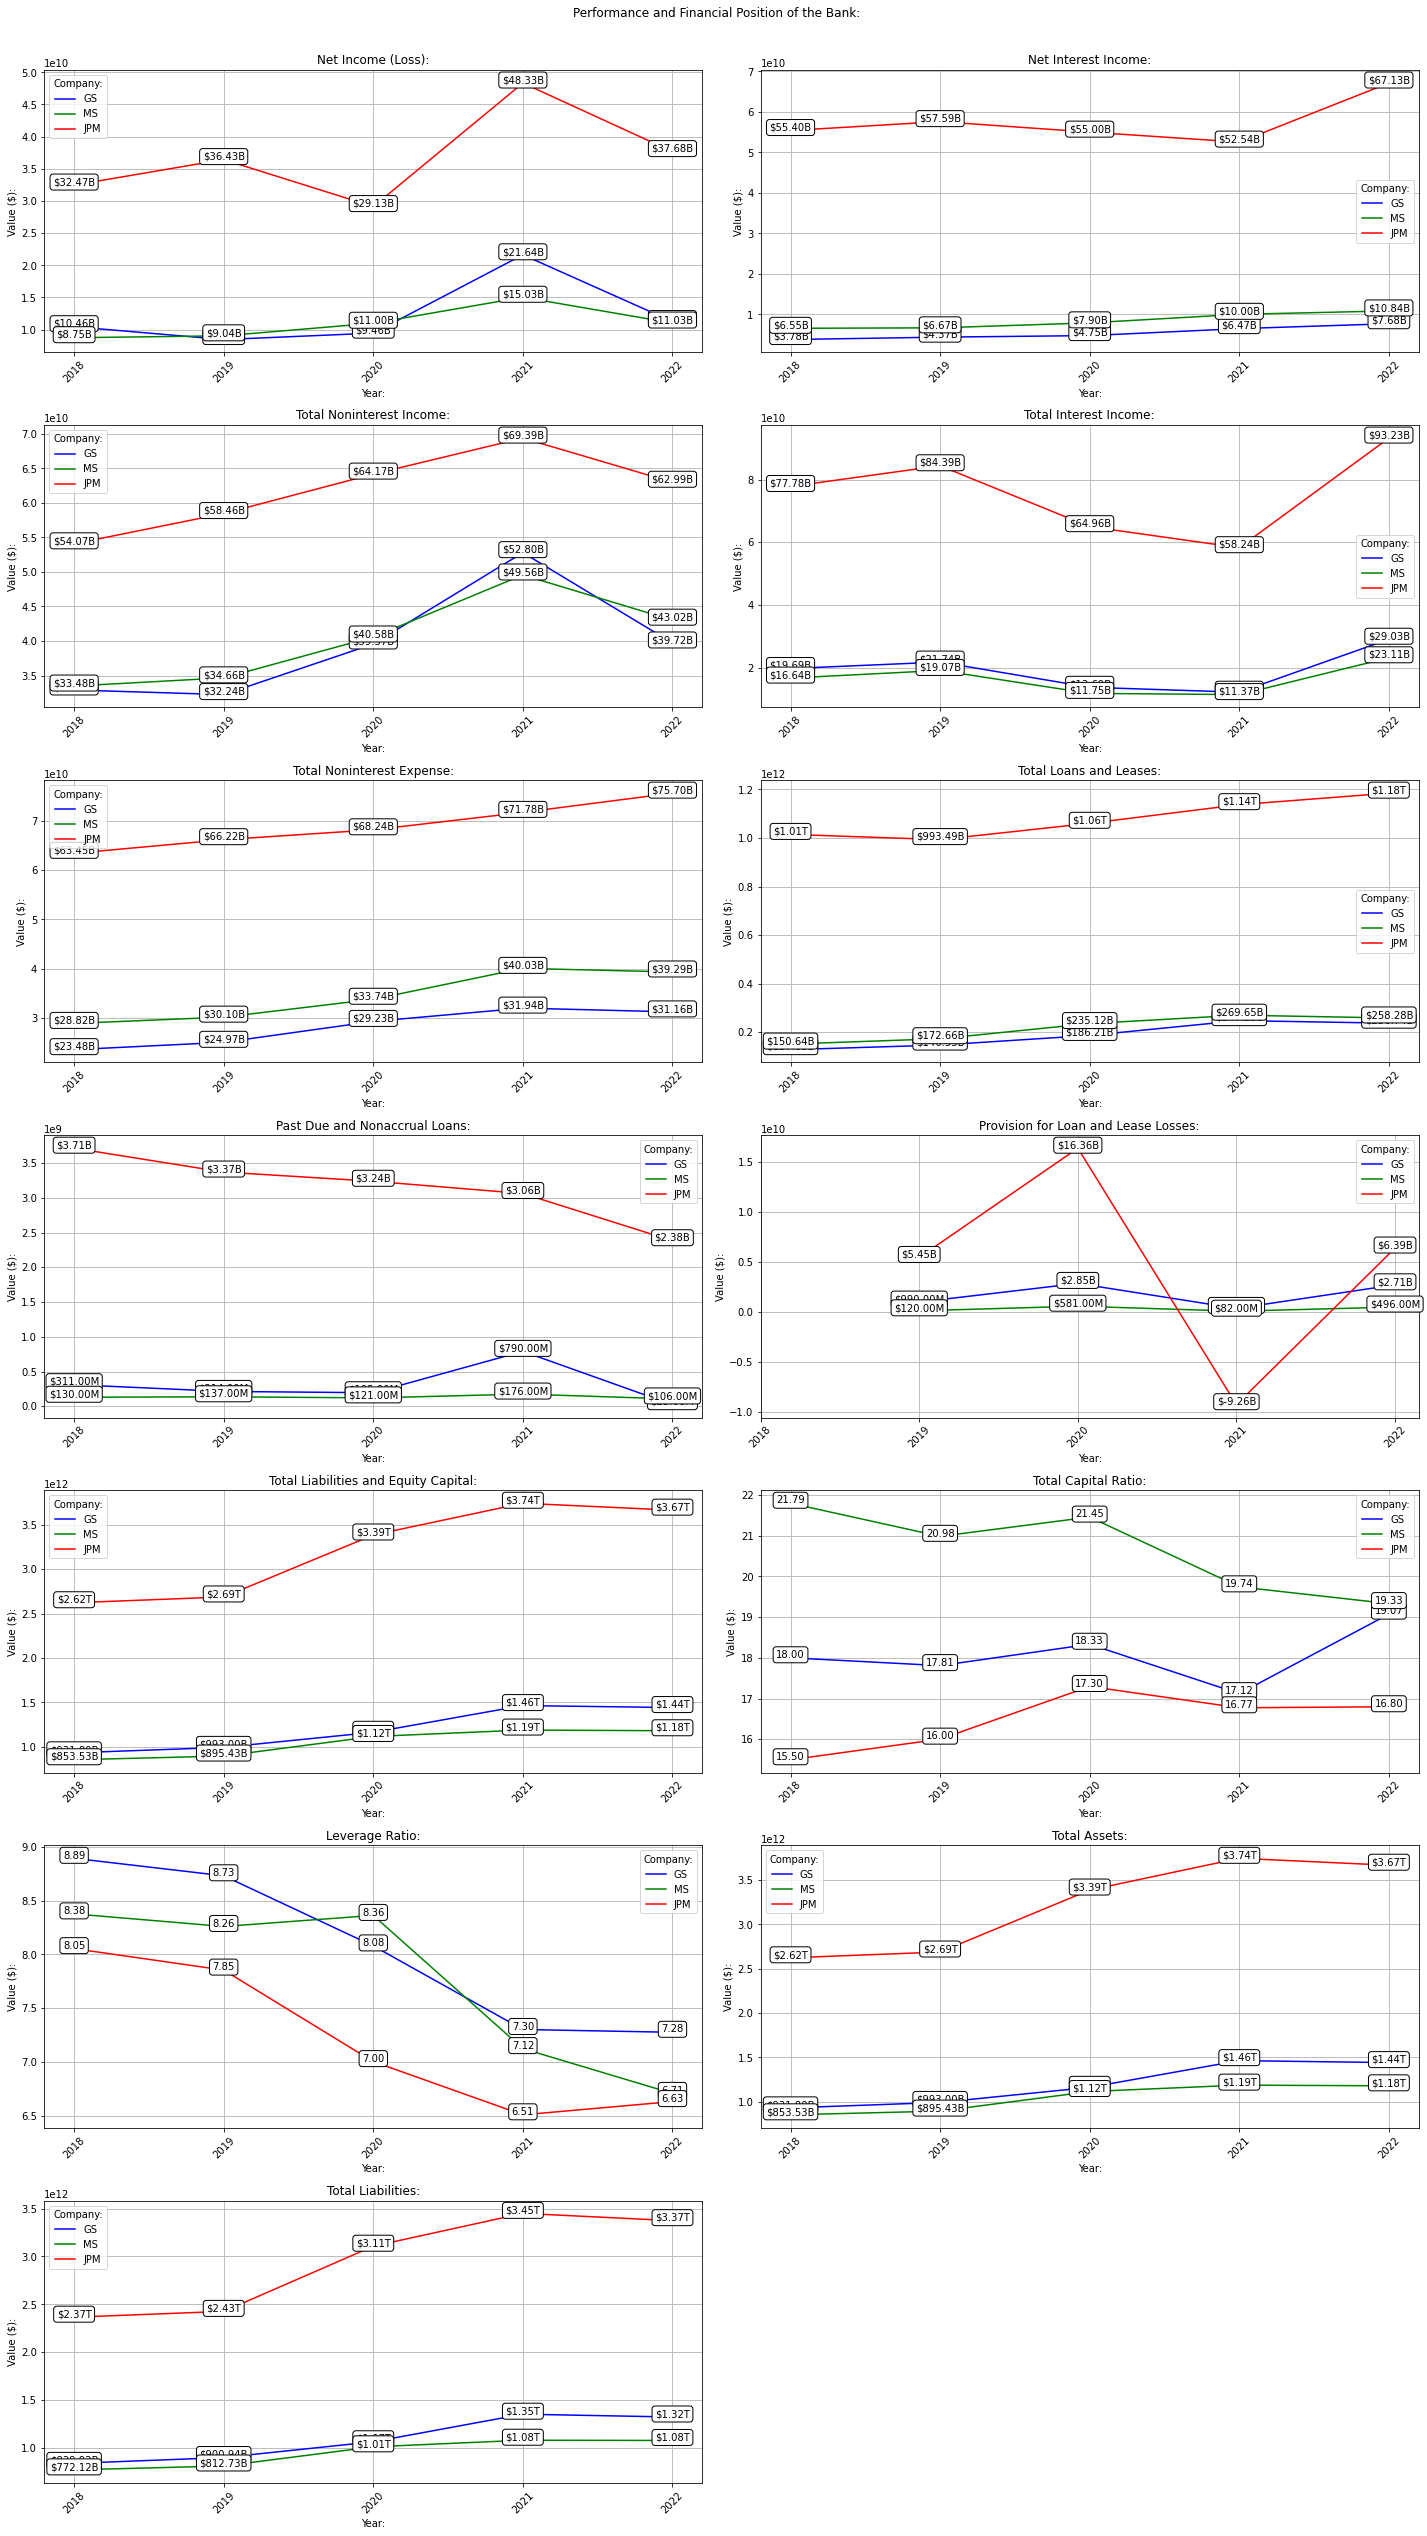

In [50]:
num_items = len(fry9c_codes)
num_rows = ceil(num_items / 2)

fig, axes = plt.subplots(num_rows, 2, figsize=(20, num_rows * 5))

if num_items % 2:
    fig.delaxes(axes[-1, -1])

axes = axes.flatten()

colors = {'GS': 'blue', 'MS': 'green', 'JPM': 'red'}

current_subplot = 0

for col_name in fry9c_codes.keys():
    for company in colors.keys():
        data = multi_index_df.xs(company, level='Company')[col_name]
        data = data.replace(pd.NA, np.nan).astype(float)
        years = data.index.get_level_values('Year').strftime('%Y').astype(int)
        axes[current_subplot].plot(years, data, label=company, color=colors[company])

        for x, y in zip(years, data):
            if np.isnan(y):
                continue

            if np.abs(y) >= 1e12:  # Trillions
                value_str = f'${y / 1e12:.2f}T'
            elif np.abs(y) >= 1e9:  # Billions
                value_str = f'${y / 1e9:.2f}B'
            elif np.abs(y) >= 1e6:  # Millions
                value_str = f'${y / 1e6:.2f}M'
            elif np.abs(y) >= 1e3:  # Thousands
                value_str = f'${y / 1e3:.2f}K'
            else:  # Less than a million
                value_str = f'{y:.2f}'

            axes[current_subplot].annotate(value_str,
                                           (x, y),
                                           textcoords="offset points",
                                           xytext=(0,0),
                                           ha='center',
                                           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=1))

    axes[current_subplot].set_title(col_name + ":")
    axes[current_subplot].set_ylabel('Value ($):')
    axes[current_subplot].set_xlabel('Year:')
    axes[current_subplot].legend(title='Company:')

    axes[current_subplot].tick_params(axis='x', rotation=45)
    axes[current_subplot].set_xticks(years)
    axes[current_subplot].set_xticklabels(years)

    axes[current_subplot].grid()
    current_subplot += 1

fig.suptitle("Performance and Financial Position of the Bank:", y=1.005)
plt.savefig("Performance and Financial Position of the Bank.png")
plt.tight_layout()

# Advanced Financial Analysis of GS, JPM, and MS (2018-2022)

## Strategic Insights and In-depth Observations

### 1. Income Stability and Diversification
- **Goldman Sachs** showed a significant spike in net income in 2021, which could be attributed to specific market conditions or strategic decisions made in response to the economic environment of the time. This spike, followed by a decline, may suggest a lack of income stability.
- **JPMorgan Chase** demonstrated more stable growth in net income, suggesting a potentially more diversified and resilient income stream.
- **Morgan Stanley**'s consistent growth up to 2021, followed by a slight decrease, indicates a steady business strategy, but the dip in 2022 may need investigation to determine if it's a temporary setback or a sign of underlying challenges.

### 2. Interest Income Growth and Economic Conditions
- The steady increase in net interest income across all three companies, especially the significant jump for **JPM** in 2022, could be related to rising interest rates or changes in their loan portfolios. This suggests a strong response to changing economic conditions, potentially indicating good risk management and adaptation strategies.

### 3. Operational Efficiency
- The rise in noninterest expenses for all companies highlights increasing operational costs. This raises questions about their operational efficiency and cost control measures. It's crucial to analyze whether these costs are investments in future growth or signs of inefficiency.

### 4. Loan Portfolio Expansion and Risk
- The growth in total loans and leases indicates an aggressive expansion in lending activities. While this can be a growth driver, it also increases exposure to credit risk, especially in uncertain economic environments. The quality of these loan portfolios in terms of defaults and delinquencies becomes a critical factor to monitor.

### 5. Risk Management and Asset Quality
- Fluctuations in past due and nonaccrual loans, especially the spike for **GS** in 2021, might indicate challenges in risk management or changes in the credit quality of borrowers. This requires deeper analysis to understand the risk profile changes over these years.

### 6. Capital Structure and Long-term Sustainability
- Increasing leverage ratios for **GS** and **MS** could be a sign of aggressive growth strategies leveraging debt. While this can boost growth, it also increases financial risk and might impact long-term sustainability. The company’s ability to manage this debt in changing interest rate environments is crucial.
- **JPM**’s slight decrease in leverage ratio suggests a conservative approach, potentially indicating a focus on long-term stability over aggressive growth.

### 7. Market Positioning and Competitive Strategy
- The comparison of these metrics across the three companies can provide insights into their competitive positioning. For example, **JPM**'s larger size and consistent growth might indicate a stronger market position, whereas **GS** and **MS** might be employing more aggressive strategies to capture market share.

## Conclusion
This in-depth analysis reveals key strategic insights about the financial health and business strategies of GS, JPM, and MS. It highlights the importance of income diversification, operational efficiency, risk management, and sustainable growth strategies. Understanding these dynamics can provide valuable lessons in financial management and strategic planning.


## Section 6: Risk Profile of the Bank from Management Discussion and Analysis (MD&A) section in 10-K or 10-Q

1. Download the latest 10-K for the bank. If it is not in 2023, you may need to check latest 10-Q.
2. Go to the Management Discussion of Risk Management in the Management Discussion and Analysis (MD&A) section
3. Based on MD&A discussion,
    
    1). Is there a Asset Liability Committe (ALCO)? Describe the framework that the bank
is using for Asset Liability Management (ALM) within the bank
    
    2). Interest Rate Risk
        * How is the bank measuring and managing interest rate risk for ALM?
        * Do they discuss duration and convexity in the context of ALM?
4. How does the bank discuss Liquidity Risk Management?
    * What are some tools and metrics that the bank is using for liquidity risk management?
    * Di they discuss deposit convexity after SVB crisis? (mostly from their 10-Q)
5. Does the bank discuss how Basel III regulations affect their ALM strategies?
6. Describe the banks ALM Models and Assumptions if they disclosed it? How do they validate their ALM models?
7. How is the bank modeling deposits and loan book? What factors are they considering? Is there a scenario analysis?
8. How is the bank adapting their ALM strategy to the rising interest rate environments (may need to see latest 10-Q)
9. Do they discuss any other strategic considerations for ALM strategy and how it fits in the broad risk management framework?

### Risk Profile & Asset Liability Management of JPM
JP Morgan's approach to Asset Liability Management (ALM) as described in their 2022 10K report involves several key strategies and structures:

1) Asset and Liability Committee (ALCO): The Asset and Liability Committee is responsible for overseeing JP Morgan's ALM. This includes managing activities and frameworks that support the balance sheet liquidity. ALCO plays a pivotal role in reviewing and managing the overall asset and liability strategy of the firm. The 10-K report establishes the following as their general framework for ALM:
- Investment in High-Quality Securities: The Treasury and Chief Investment Office (CIO) of the firm focus on achieving ALM objectives by investing in high-quality securities. These securities are managed for the longer-term and form a part of the firm’s investment securities portfolio
- Use of Derivatives: In addition to investing in securities, the Treasury and CIO also utilize derivatives to meet the firm’s ALM objectives. This approach helps in risk management particularly
- Cash Position Management: The management of the firm’s cash position is primarily handled through deposits at central banks and investments in short-term instruments. This is a crucial aspect of their ALM strategy as it ensures liquidity and funding risk is appropriately managed

2) The CTC Risk Committee determines JPM's structural interest rate risk policy (subject ot approval by Board Risk Committee)
- JPM business units transfer interest rate risk to the Chief Investment Office through Funds Transfer Pricing (FTP)
- Earnings-At-Risk models are used to stress test beyond VaR modeling: this activity includes forecasting the balance sheet, determining deposit betas, and assessing risk to both in various monetary/Fed policy scenarios
    - The sensitivity to +- 100 basis point parallel shifts in short/long interest rates are shown; an important observation is that JPM notes that for short term parallel interest rate shifts, the impact to the balance sheet is primarily due to liabilities repricing, and for parallel shifts in long-term interest rates, the impact is felt in assets repricing (maturity transformation)
    - The principal scenarios modeled using Earnings-At-Risk in JPM's 10-K are Parallel shifts, Steeper yield curve, and flatter yield curve with various baseline interest rates.

4) JPM has its own dedicated Liquidity Risk Management function which interfaces with other key risk managers (Firm- and LOB-level ALCO's, Risk Committees
- Regular stress testing is also an integral parg of LRM function, including both standardized and present - circumstance scenarios for the firm and its subsidiaries
- The corporate structure for JPM also necessitates a certain level of control/oversight; the parent company acts as the funding source for the intermediate holding company JPMorgan Chase Holdings, LLC, which then further provides funding to the operations of subsidiary companies.
- Part of their Liquidity Risk Management function is the establishment of a Contingency Funding Plan in line with LCR (Liquidity Coverage Ratio):
    -   30 days' cash outflow provision is maintained in High-Quality Liquid Assets (HQLA)*
        - The firm does not report any non-transferable HQLA assets belonging to JPMorgan Chase Bank, NA that cannot be moved to its non-banking subsidiaries; this is to ensure that the parent company does not overreport
- JPM maintains compliance with the 100% minimum NSFR (Net-Stable-Funding-Ratio) requirement
- An interesting quote from the end of the Liquidity Risk Management section - 'Although available, the Firm does not view this borrowing capacity at the Federal Reserve BAnks discount window and the other central banks as a primary source of liquidity

5) JPM maintains its Basel III standardized risk-based ratios at a level in excess/more binding than the Basel III advanced
- JPM's Basel III standardized CET1 (Common Equity Tier 1) capital ratio (CET1/RWA) at December 31, 2022 was 13.2% (Basel III requirement: 4.5 (7*) %)
- Starting January 1, 2022, JPM adopted the new Standardized Approach for Counterparty Credit Risk (SA-CCR) under Basel III standards for determining Exposure at Default (EAD); this had a significant impact on their risk profile, as the higher exposure typically calculated by the SA-CCR model (compared to previous CEM/SM) will increase Risk-Weighted Assets
- However, in this instance, this same effect is almost evidentiary of JPM's legendary "fortress balance sheet": the change in calculation still only affected their risk profile to the tune of 30 basis points.

6) ALM Models & Assumptions
- JPM's ALM is modeled by various regulatory standards and models derived from such, particularly RWA (Risk-Weighted Assets) and LCR (Liquidity Coverage Ratio). Both are strictly maintained, usually with plenty of threshold, above certain standards
- JPM's Liquidity Coverage Ratio for the Banking segment has averaged over 125% with comparatively little movement - this illustrates a generally conservative and stability-seeking rather than growth-driven approach
- 


7) JPM's reputation for funding stability is backed up by the information in their 10-Q, showing a dominant funding percentage coming from consumer and wholesale operating deposits.
- Interestingly, JPM notes that it prefers averages to period end deposit balances for modeling: generally they note a decrease in deposits in their most recent 10-Q (iss. Nov 1 2023) 
- The decrease in deposits is attributed to the high interest rate environment affecting multiple pieces of their business; the commercial banking segment and asset & wealth management segment both saw attrition due to shifts to higher yielding assets while simultaneously consumer deposits fell due to high demand

8) JPM's allowance for credit losses has increased from $18.7 billion in December 31, 2021 to $24.3 bn as of September 30 2023. In the last year, they report $707 million increase in consumer (specifically credit card) expected losses as well as $623 million in wholesale credit losses, driven by deteriorating credit and macroeconomic outlook.


9) The strategic considerations JPM takes into account are built into its risk management structure and process, which is widely viewed as industry-leading and as a model for risk management, particularly at a Globally Systematically Important Bank (GSIB). As almost the prototypical GSIB, JPM:
- Classifies its risk in to strategic, credit/investment, market risk and operational risk, and has a designated "Independent Risk Management (IRM)" function
- Board of directors has risk committee, but CEO appoints Chief Risk Officer that oversees CRO's for each of the lines of business and the CCO (Chief Compliance Officer)
- Three lines of defense model implemented - 
   - first line of defense - each LOB owns its own risk
   - second line of defense - IRM function
  - third line of defense - internal audit (conducted by General Audtior and Audit Committee)
- Risk appetite is set by frameworks approved by the CEO and CRO and Board Risk Committee. This includes the JPM "How We Do Business Principles" and also takes input from operating and senior management teams in each LOB.
- They also have a firmwide valuation governance forum (VGF) responsible for handling valuation risk




The Risk Management section of JPM's 10-K and 10-Q highlight the effects of the shifting regulatory environment of banks:
- The CECL capital benefit given to banks during the COVID-19 pandemic is being phased out
- A section on the most recent 10-Q analyzes the effects of a proposed change in Basel III to standardize modeling (prevent internal modeling) of RWA (risk-weighted assets), something the authors note greatly affects large banks and would increase their required CET1 capital by approximately 25%
- This can be compared to the previous change in the standards when SA-CCR was adopted, both of which ultimately raised the calculation of risk-weighted assets and by extension capital requirements for banks.

## Section 7: Risk Profile of the Bank from FRY9-C and 10-K / 10-Q

Analyze the risk profile of the bank (under the same headings as the bank risks lecture).
1. Pay special attention to operational risk (fraud etc,)
2. Asset Side Risks
3. Liability side risks
4. Off-balance-sheet risks
5. Regulatory Risk
6. Exposure to real estate markets

In [52]:
csv_file = 'data/JPM_FRY9C_20221231.csv'

codes = {
    'Total risk-weighted assets (item 28 minus items 29 and 30)': 'BHCKG641',
    'Total capital (sum of items 26 and 44.a)': 'BHCA3792',
    'Total loans and leases (sum of items 1 through 8.b) Past due 30 through 89 days and still accruing': 'BHCK1406',
    'Total loans and leases (sum of items 1 through 8.b) Past due 90 days or more and still accruing' : 'BHCK1407', 
    'Total loans and leases (sum of items 1 through 8.b) Nonaccrual': 'BHCK1403',
    'Total loans and leases held for investment and held for sale': 'BHCK2122',
    'Total liabilities (sum of items 13 through 20)': 'BHCK2948',
    'Total liabilities and equity capital (sum of items 21 and 28)': 'BHCK3300',
    'Total leverage exposure for the supplementary leverage ratio (SLR)': 'BHCALE88',
    'Total assets (sum of items 1 through 11)' : 'BHCK2170',
    'Provision for loan and lease losses': 'BHCKJJ33',
    'Total assets (sum of items 1 through 11)' : 'BHCK2170',
    'Current credit exposure across all derivative contracts covered by the regulatory capital rules': 'BHCKG642',
    'Total risk-weighted assets (item 28 minus items 29 and 30)': 'BHCKG641',
    'High volatility commercial real estate exposures': 'BHCKS445',
    'Total assets (sum of items 1 through 11)' : 'BHCK2170'
}

df = pd.read_csv('data/JPM_FRY9C_20221231.csv')
df = df[df['ItemName'].isin(codes.values())]
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
df.drop('Description', axis=1, inplace=True)
df.set_index('ItemName', inplace=True)

# Operational Risk:
    # Operational Risk Capital Ratio = Risk-Weighted Assets / Operational Risk Capital
df.loc['(Operational Risk) Operational Risk Capital Ratio'] = (df.loc[codes['Total risk-weighted assets (item 28 minus items 29 and 30)']] /
                                           df.loc[codes['Total capital (sum of items 26 and 44.a)']])
# Asset Side Risks:
    # NPL Ratio = Non-Performing Loans / Total Loans
df.loc['(Asset Side Risks) NPL Ratio'] = ((df.loc[codes['Total loans and leases (sum of items 1 through 8.b) Past due 30 through 89 days and still accruing']] +
                       df.loc[codes['Total loans and leases (sum of items 1 through 8.b) Past due 90 days or more and still accruing']] +
                       df.loc[codes['Total loans and leases (sum of items 1 through 8.b) Nonaccrual']])
                       / df.loc[codes['Total loans and leases held for investment and held for sale']])
# Liability Side Risks:
    # Net Stable Funding Ratio = Available Stable Funding / Required Stable Funding
df.loc['(Liability Side Risks) Net Stable Funding Ratio'] = (df.loc[codes['Total leverage exposure for the supplementary leverage ratio (SLR)']] / 
                                      df.loc[codes['Total liabilities and equity capital (sum of items 21 and 28)']])
    # Supplementary Leverage Ratio (SLR) = Total leverage exposure for the supplementary leverage ratio (SLR) / Total assets
df.loc['(Liability Side Risks) Supplementary Leverage Ratio (SLR)'] = (df.loc[codes['Total liabilities (sum of items 13 through 20)']] / 
                                            df.loc[codes['Total assets (sum of items 1 through 11)']])
# Off-Balance-Sheet Risks:
    # Off-Balance-Sheet Exposure Ratio =  Off-Balance-Sheet Exposure / Total Assets
df.loc['(Off-Balance-Sheet Risks) Off-Balance-Sheet Exposure Ratio'] = (df.loc[codes['Provision for loan and lease losses']] / 
                                          df.loc[codes['Total assets (sum of items 1 through 11)']])
# Regulatory Risk:
    # Regulatory Capital Ratio = Regulatory Capital / Risk-Weighted Assets
df.loc['(Regulatory Risk) Regulatory Capital Ratio'] = (df.loc[codes['Current credit exposure across all derivative contracts covered by the regulatory capital rules']] / 
                                  df.loc[codes['Total risk-weighted assets (item 28 minus items 29 and 30)']])
# Exposure to Real Estate Markets:
    # Real Estate Exposure Ratio = Real Estate Exposure / Total Assets
df.loc['(Exposure to Real Estate Markets) Real Estate Exposure Ratio'] = (df.loc[codes['High volatility commercial real estate exposures']] / 
                                  df.loc[codes['Total assets (sum of items 1 through 11)']])

df.drop(codes.values(), inplace=True)
for index, row in df.iterrows():
    print(index + ":" , round(row['Value'], 3))

(Operational Risk) Operational Risk Capital Ratio: 5.953
(Asset Side Risks) NPL Ratio: 0.012
(Liability Side Risks) Net Stable Funding Ratio: 1.191
(Liability Side Risks) Supplementary Leverage Ratio (SLR): 0.92
(Off-Balance-Sheet Risks) Off-Balance-Sheet Exposure Ratio: 0.002
(Regulatory Risk) Regulatory Capital Ratio: 0.048
(Exposure to Real Estate Markets) Real Estate Exposure Ratio: 0.0


# JPMorgan Chase Financial Ratio Analysis (As of December 2022)

## Overview
This analysis examines key financial ratios derived from JPMorgan Chase's data as of December 31, 2022. These ratios offer insights into operational risks, asset and liability side risks, off-balance-sheet exposures, regulatory risks, and exposure to real estate markets.

## Formulas and Insights

### 1. Operational Risk Capital Ratio
- **Formula:** `Operational Risk Capital Ratio = Total Risk-Weighted Assets / Total Capital`
- **Value:** 5.953
- **Insight:** This ratio indicates the proportion of risk-weighted assets covered by the bank's total capital. A higher ratio suggests a stronger capital base relative to the risk level of assets. JPMorgan's ratio of 5.953 implies a robust capital buffer against operational risks.

### 2. NPL (Non-Performing Loans) Ratio
- **Formula:** `NPL Ratio = (Past Due Loans + Nonaccrual Loans) / Total Loans`
- **Value:** 0.012
- **Insight:** The NPL ratio measures the proportion of loans in poor standing (either past due or nonaccruing) to total loans. A lower ratio is preferable, indicating fewer credit issues. JPMorgan's low NPL ratio of 0.012 reflects strong credit quality in its loan portfolio.

### 3. Net Stable Funding Ratio (NSFR)
- **Formula:** `Net Stable Funding Ratio = Total Leverage Exposure / Total Liabilities and Equity Capital`
- **Value:** 1.191
- **Insight:** NSFR assesses the stability of a bank's funding structure. A value greater than 1 indicates a stable funding profile, suggesting JPMorgan has sufficient stable funding to cover its leverage exposure.

### 4. Supplementary Leverage Ratio (SLR)
- **Formula:** `Supplementary Leverage Ratio = Total Liabilities / Total Assets`
- **Value:** 0.92
- **Insight:** SLR measures the bank's leverage by comparing its total liabilities to its total assets. A lower ratio indicates less reliance on debt. JPMorgan's SLR of 0.92 implies a relatively moderate leverage level, suggesting prudent risk management.

### 5. Off-Balance-Sheet Exposure Ratio
- **Formula:** `Off-Balance-Sheet Exposure Ratio = Provision for Loan and Lease Losses / Total Assets`
- **Value:** 0.002
- **Insight:** This ratio gauges the significance of off-balance-sheet items relative to total assets. JPMorgan's low ratio indicates minimal exposure to off-balance-sheet risks, highlighting effective risk management practices.

### 6. Regulatory Capital Ratio
- **Formula:** `Regulatory Capital Ratio = Current Credit Exposure / Total Risk-Weighted Assets`
- **Value:** 0.048
- **Insight:** This ratio assesses the adequacy of regulatory capital against credit exposure. JPMorgan's ratio suggests adequate capitalization to cover potential credit risks under regulatory requirements.

### 7. Real Estate Exposure Ratio
- **Formula:** `Real Estate Exposure Ratio = High Volatility Commercial Real Estate Exposures / Total Assets`
- **Value:** 0.0
- **Insight:** The ratio measures exposure to the volatile real estate sector. JPMorgan's ratio of 0.0 indicates negligible or very low exposure to high-volatility real estate markets, which minimizes the related risk.

## Conclusion
JPMorgan Chase's financial ratios as of December 2022 demonstrate a strong capital base, high credit quality, moderate leverage, minimal off-balance-sheet risks, adequate regulatory capital, and low exposure to high-volatility real estate markets. These indicators collectively suggest a robust financial health and sound risk management strategies.


## Section 8: Off-balance sheet activities of the Bank from FRY9-C and 10-K / 10-Q

### 1. Off balance sheet growth over years

JPM's off balance sheet activity, as with many banks, is a critical component of their function. 
- Credit exposure in the consumer and credit card segments grew significantly from 12/31/2022; beyond this, their off-balance sheet activity rose overall by a significant percentage, although their credit exposure to the asset manager category nearly doubled.
- On the asset side, their asset mix has weakend somewhat since 2022; from 2022 to Q3 2023, they have seen 10% reductions in their level 1 assets, but sharp increases in their level 2 and 3 loan assets

### 2. Components of off-balance sheet

The components of JPM's off balance sheet activities are as follows: 
- Derivatives Trading: Derivatives such as futures, options, and swaps are common off-balance sheet items. These financial instruments derive their value from an underlying asset, such as commodities, currencies, or interest rates. G-SIBs often engage in large-scale derivatives trading, which can lead to substantial risks if the market moves unfavorably.
- Securitization: This involves pooling various types of contractual debt like mortgages, car loans, or credit card debt obligations, and selling the consolidated debt as bonds to investors. While these assets are moved off the bank’s balance sheet, the bank may still retain some risk, especially if they provide credit enhancements or liquidity facilities to the securitization structure.
- Guarantees and Letters of Credit: Banks issue guarantees or letters of credit on behalf of clients to assure payment. These are contingent liabilities and only become actual liabilities if the client fails to meet their obligations.
- Commitments to Extend Credit: These are agreements to provide loans to clients in the future. Until the loan is actually made, it does not appear on the balance sheet, but it represents a potential obligation.
- Conduits and Special Purpose Entities (SPEs): Banks often set up SPEs to manage certain assets or conduct specific transactions. These entities can hold assets or liabilities not reflected on the bank's primary balance sheet, allowing the bank to achieve financing or investment objectives while keeping the associated risks off its books.
- Repo Agreements: In a repurchase agreement (repo), a bank sells securities with an agreement to repurchase them at a later date. The securities are off the balance sheet during the repo period, even though the bank retains some risk exposure.
- Foreign Exchange Contracts: Similar to derivatives, these are commitments to buy or sell foreign currency at a future date at a predetermined price. These contracts are off-balance sheet until they are settled.
- Operational Leases: If a bank leases assets and the lease is structured as an operational lease, it does not need to be recorded on the balance sheet.
Asset Management and Custodial Services: Managing assets for clients or providing custodial services often involves significant off-balance sheet activities.

### 3. Bank’s Derivative Usage. What are the biggest components?

JPM has total derivative trading assets of approx $615.5B and liabilities of $603.5B, including both designated hedges and non-hedge derivatives
- The vast majority of gross derivative receivables at JPM (as of 9/30/2023)are in interest rate and forex derivatives, constituting more than 85% of assets, with equities the next largest at a further 9%
- In notional terms, the derivatives on JPM's books are majority interest rate swaps, with the most significant other categories being forex cross-currency swaps and forward/futures contracts, with all other classes far behind.
- Likewise, the vast majority of gross derivative payables at JPM are in the same category, but interestingly, equity derivative payables (non-hedge) exceed the asset value of the derivatives receivable, while forex is approximately even and interest rate is far positive.

### 4. Securitization activities

JPM describes its securitization activities as follows:
- The firm "sponsors" Variable Interest Entities (VIE), which issues financial securitized products. Through its sponsored VIEs, JPM holds some 234B in securitized assets, roughly 3/4 of which are nonconsolidated.
- Interestingly, JPM provides government non-treasury securities to its VIEs. These VIEs, in aggregate, hold a significant but minority percentage of their assets in prime real estate (very small amount in subprime) but with the bulk in commercial/other, which includes commercial real estate and non-mortgage consumer receivables
- Generally, however, the firm's most recent 10-Q report shows a general and significant decrease in the amount of principal securitized through 3 quarters 2023 verus the same period of 2022 

### 5. Level 1, Level 2 and Level 3 assets of the bank

The bulk of JPM's business is in level 2 assets and liabilities; of 586.238B in total (fair value) liabilities, 967B of total level 2 assets are recorded, but this is reduced by 561B of derivative netting adjustments.

### 6. Value at Risk, Expected Shortfall and other Risk Measures noted in the 10-K/10-Q

The JPM Value-at-Risk (VaR) model is outlined in two distinct parts in the 10-K as follows:
    - Firm Risk Management VaR is calculated assuming a one-day holding period and expected tail-loss at the 5%(95% confidence) level
        -  This model includes credit derivative hedges, which regulatory VaR does not
    - Regulatory VaR is calculated separately daily in accordance with relevant regulation and is the value used to determine compliance with Basel III capital rules
        - This model instead assumes a 10 business-day holding period and tail loss methodology at 1%(99% confidence) level
    - The VaR model is backtested daily in accordance with Basel III capital rules for which in 2022 they observed 17 backtesting exceptions (daily VaR - exceeding loss), and posted a very strong 136 backtesting gain days

## Additional Comments

Note:
1. You are expected to learn some new material through this assignment, in addition to the material covered through lectures in the class
2. Present the information in a graphical format to the extent possible. Use Python to generate graphs
3. Part of the task is to decide which financial information is relevant and which is not.
4. Focus on both income statement and balance sheet

## Resources

1. FDIC, NIC and FFIEC websites
2. <b>important </b>https://www.federalreserve.gov/boarddocs/supmanual/bhcpr/UsersGuide13/0313.pdf
3. http://www.federalreserve.gov/boarddocs/supmanual/default.htm#bhcuser
4. https://www.fdic.gov/search/help.html
5. http://www.ffiec.gov/nicpubweb/nicweb/nichome.aspx
6. See the Bank Holding Company Performance Report (BHCPR) at
    * https://www.ffiec.gov/npw/Institution/TopHoldings.
    * Click on your respective bank and then select BHCPR

# Links

[Reporting on JP Morgan Chase from the National Information Center of the Federal Financial Institutions Examination Council](https://www.ffiec.gov/npw/Institution/Profile/1039502?dt=20190519)

[All 10-K Filings to the SEC from JP Morgan Chase](https://jpmorganchaseco.gcs-web.com/?field_nir_sec_form_group_target_id%5B%5D=471&field_nir_sec_date_filed_value=)

[JP Morgan at Yahoo Finance](https://finance.yahoo.com/quote/JPM/)

## Installation Instructions

!brew install graphviz

!pip install yfinance selenium networkx plotly pydot graphviz pygraphviz

conda install -c anaconda openpyxl


conda install -c conda-forge python-kaleido # This is needed to export images from plotly